Name: Kaushik Ilango
CWID: 20011241

Previously in HW1 I used the dataset as is and predicted for 5 possible labels. Now I have converted the data into binaries which means I will be doing a binary classification. For this I have converted all the ratings that are 4 and 5 to 1 and remaining to 0. Below I have also analysed some statistics for the same. As always let's import some libraries.

In [1]:
import pandas as pd
import tensorflow as tf
import numpy as np
import warnings
warnings.filterwarnings('ignore')

Reading the data into a dataframe

In [2]:
amz_rev = pd.read_csv('amazon_reviews.csv')

Here I have completely used the nltk libraries to solve the problem of pre-processing the text data since it gives us the best result when doing text related tasks. I have used both the regex and stopwords to remove punctuations and stopwords from the dataset

In [3]:
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords

nltk.download('stopwords')

def setup_data(corpus):
    print("Cleaning and removing stopwords from data ... ")
    cleaned_corpus = []
    stop_words = set(stopwords.words('english'))  # Define stop words for English

    for doc in corpus:
        tokenizer = RegexpTokenizer(r'\w+')
        words = tokenizer.tokenize(doc.lower())
        filtered_words = [word for word in words if word not in stop_words]
        cleaned_corpus.append(filtered_words)

    count = len(cleaned_corpus)
    print(f"Done cleaning and removing stopwords from {count} data")
    return cleaned_corpus

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kilan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Replacing empty string to a string "NA" which will make it easier for me to handle them in model training

In [4]:
amz_rev['reviewText'].fillna('NA', inplace=True)

Executing the nltk functions to clean and pre-process the data.

In [5]:
X = setup_data(amz_rev['reviewText'])

Cleaning and removing stopwords from data ... 
Done cleaning and removing stopwords from 4915 data


In [6]:
def draw_insights(corpus):
    min = 0
    max = 0
    total = 0
    for doc in corpus:
        if len(doc) < min:
            min = len(doc)
        if len(doc) > max:
            max = len(doc)
        total = total + len(doc)
    avg = total/len(corpus)
    print(f"Min: {min}, Max: {max}, Avg: {avg}")

In [7]:
draw_insights(X)

Min: 0, Max: 826, Avg: 26.468565615462868


This function is used to convert the 5 multi-class label to binary labels

In [8]:
def convert_binaries(corpus):
    y = []
    print("Converting to binaries ... ")
    for k in corpus:
        if k > 3:
            y.append(1)
        else:
            y.append(0)
    return y

Executing the above on the 'overall' column of the dataframe

In [9]:
amz_rev['overall'] = convert_binaries(amz_rev['overall'].tolist())
y = amz_rev['overall'].tolist()

Converting to binaries ... 


In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="darkgrid")
def plot_count(y,xlabel):
    ax = sns.countplot(x = y)
    for p in ax.patches:
        ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='baseline')
    ax.set_xlabel(xlabel,fontsize=15)

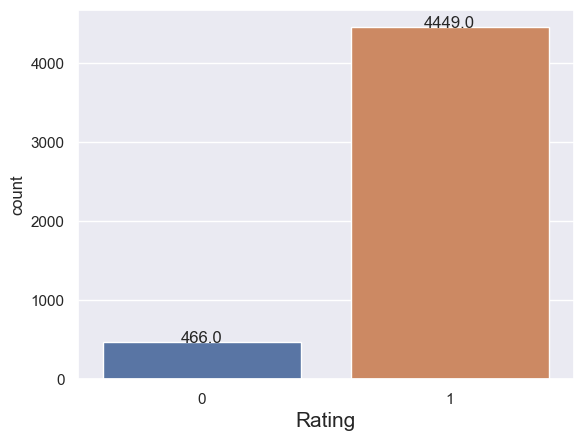

In [11]:
plot_count(amz_rev['overall'],'Rating')
plt.show()

This function is used to retrieve vocabulary used in the dataset. This is a re-used function from previous code HW1

In [12]:
def get_vocab(corpus):
    vocab = []
    vocab = [x for line in corpus for x in line]
    vocab = list(set(vocab))
    vocab = sorted(vocab)
    return vocab

Setting up some globals so that these can be used in training. I have set the MAX_SEQUENCE_LENGTH to 100 since it gives us a best shot between huge and medium sized text reviews

In [13]:
MAX_SEQUENCE_LENGTH = 100
VOCAB_SIZE = len(get_vocab(X))

This function is now being developed to convert the text to numbers (tokenization) and since we are random embedding which will be done directly in the model we can just tokenize them and pad them using the in-build functions tensorflow provides.

In [14]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

def get_sequences(corpus):
    tokenizer = Tokenizer(num_words=VOCAB_SIZE)
    tokenizer.fit_on_texts(corpus)
    sequences = tokenizer.texts_to_sequences(corpus)
    padded_sequences = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')
    return padded_sequences

Executing the above function to store all the tokens in the below variable

In [15]:
X_seq = get_sequences(X)

Re-used function from HW1 to split dataset into train,test,val

In [16]:
from sklearn.model_selection import train_test_split
def train_test_val_split(X,y, test_size=0.1, val_size = 0.1,random_state=16):
    total_test_size = test_size + val_size
    X_train, X_t, y_train, y_t = train_test_split(X, y, test_size=total_test_size, random_state=random_state)
    X_val, X_test, y_val, y_test = train_test_split(X_t, y_t, test_size=test_size/total_test_size, random_state=random_state)
    return X_train, X_val, X_test, y_train, y_val, y_test

Execting the above function on tokens and the labels created from to_binary function

In [17]:
X_train, X_val, X_test, y_train, y_val, y_test = train_test_val_split(X_seq,y)

I noticed that the labels were not in numpy type but rather a list type which threw in errors during training so I have converted them into np.arrays. I could Hvae directly converted them splitting as well.

In [18]:
y_test = np.array(y_test)
y_train = np.array(y_train)
y_val = np.array(y_val)

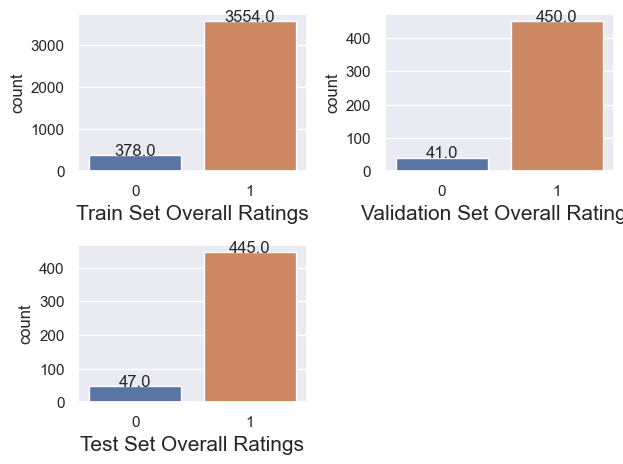

In [19]:
plt.subplot(2,2,1)
plot_count(y_train,xlabel="Train Set Overall Ratings")
plt.subplot(2,2,2)
plot_count(y_val,xlabel="Validation Set Overall Ratings")
plt.subplot(2,2,3)
plot_count(y_test,xlabel="Test Set Overall Ratings")
plt.tight_layout()
plt.show()

Importing layers and callbacks for early stopping of model training

In [20]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, MaxPooling1D, Conv1D,Flatten
from tensorflow.keras.callbacks import EarlyStopping

I have built the model as requested in the requirements. The embeddings are randomized and hence will learnt in the first layer of the model as we train more data. The next layer is the LSTM Layer -1 with input of 128 and further reduced to 64 in layer-2 from which we use a sigmoid activation function to get a single value (0 or 1)

In [21]:
RNN_model = Sequential()

RNN_model.add(Embedding(VOCAB_SIZE, output_dim = 128, input_length=MAX_SEQUENCE_LENGTH))
RNN_model.add(LSTM(128,return_sequences=True))
RNN_model.add(LSTM(64))
RNN_model.add(Dense(1, activation='sigmoid'))


RNN_model.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['accuracy'])

Printing out the model summary

In [22]:
RNN_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 128)          1071744   
                                                                 
 lstm (LSTM)                 (None, 100, 128)          131584    
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 1252801 (4.78 MB)
Trainable params: 1252801 (4.78 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


I have this line of code for early stopping because while training I noticed that the val_loss delta was not changing that much and felt like I could stop the training after few epochs of low delta

In [23]:
earlystopping = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 3,min_delta = 0.008)

Fitting the model on our dataset and running epochs

In [24]:
RNN_model.fit(X_train,y_train,validation_data=(X_val,y_val),epochs=100,batch_size=128,callbacks=[earlystopping])

Epoch 1/100
31/31 [==============================] - 14s 372ms/step - loss: 0.5948 - accuracy: 0.8512 - val_loss: 0.4943 - val_accuracy: 0.9165
Epoch 2/100
31/31 [==============================] - 10s 324ms/step - loss: 0.4449 - accuracy: 0.9039 - val_loss: 0.3811 - val_accuracy: 0.9165
Epoch 3/100
31/31 [==============================] - 10s 328ms/step - loss: 0.3679 - accuracy: 0.9039 - val_loss: 0.3253 - val_accuracy: 0.9165
Epoch 4/100
31/31 [==============================] - 11s 370ms/step - loss: 0.3343 - accuracy: 0.9039 - val_loss: 0.3016 - val_accuracy: 0.9165
Epoch 5/100
31/31 [==============================] - 12s 379ms/step - loss: 0.3215 - accuracy: 0.9039 - val_loss: 0.2918 - val_accuracy: 0.9165
Epoch 6/100
31/31 [==============================] - 13s 422ms/step - loss: 0.3168 - accuracy: 0.9039 - val_loss: 0.2875 - val_accuracy: 0.9165
Epoch 7/100
31/31 [==============================] - 10s 320ms/step - loss: 0.3150 - accuracy: 0.9039 - val_loss: 0.2854 - val_accuracy:

Let's now evaluate and see how the model performs on the test data

In [25]:
RNN_model.evaluate(X_test,y_test)

16/16 [==============================] - 1s 34ms/step - loss: 0.3124 - accuracy: 0.9045


[0.3124070465564728, 0.9044715166091919]

In [26]:
y_preds = RNN_model.predict(X_test)

16/16 [==============================] - 1s 39ms/step


In [27]:
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,f1_score,precision_score,recall_score

y_preds_RNN = np.round(y_preds)
print(f'Accuracy of the model is {accuracy_score(y_test,y_preds_RNN)}')
print(classification_report(y_test,y_preds_RNN))
print(confusion_matrix(y_test,y_preds_RNN))

Accuracy of the model is 0.9044715447154471
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        47
           1       0.90      1.00      0.95       445

    accuracy                           0.90       492
   macro avg       0.45      0.50      0.47       492
weighted avg       0.82      0.90      0.86       492

[[  0  47]
 [  0 445]]


In [28]:
import gensim.downloader as api
def load_embedding_model():
    wv_from_bin = api.load("glove-wiki-gigaword-200")
    print("Loaded vocab size %i" % len(list(wv_from_bin.index_to_key)))
    return wv_from_bin
wv_from_bin = load_embedding_model()

Loaded vocab size 400000


In [29]:
import random
def get_matrix_of_vectors(wv_from_bin, required_words):

    words = list(wv_from_bin.index_to_key)
    print("Shuffling words ...")
    random.seed(225)
    random.shuffle(words)
    words = words[:10000]
    print("Putting %i words into word2ind and matrix M..." % len(words))
    word2ind = {}
    M = []
    curInd = 0
    for w in words:
        try:
            M.append(wv_from_bin.get_vector(w))
            word2ind[w] = curInd
            curInd += 1
        except KeyError:
            continue
    for w in required_words:
        if w in words:
            continue
        try:
            M.append(wv_from_bin.get_vector(w))
            word2ind[w] = curInd
            curInd += 1
        except KeyError:
            continue
    M = np.stack(M)
    print("Done.")
    return M, word2ind

In [30]:
from sklearn.decomposition import TruncatedSVD
def reduce_to_k_dim(M,k=2):
    print(f"Reducing to {k} dimensions...")
    svd = TruncatedSVD(n_components=k, n_iter=10, random_state=16)
    M_reduced = svd.fit_transform(M)
    return M_reduced

In [31]:
M2,word2index2 = get_matrix_of_vectors(wv_from_bin,get_vocab(X))

Shuffling words ...
Putting 10000 words into word2ind and matrix M...
Done.


In [32]:
MAX_SEQUENCE_LENGTH = 100
VOCAB_SIZE = len(get_vocab(X))
BATCH_SIZE = 20
M2 = reduce_to_k_dim(M2,128)

Reducing to 128 dimensions...


In [33]:
data_sequences = [[word2index2.get(word, 0) for word in data_point] for data_point in X]
padded_data = pad_sequences(data_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')
padded_data.shape

(4915, 100)

In [34]:
y = np.array(y)
X_train, X_val, X_test, y_train, y_val, y_test = train_test_val_split(padded_data,y)

In [35]:
CNN_model = Sequential()

vocab_size = len(word2index2)  # Add 1 for the OOV token
CNN_model.add(Embedding(input_dim=vocab_size, output_dim=M2.shape[1], weights=[M2], input_length=MAX_SEQUENCE_LENGTH, trainable=False))
CNN_model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
CNN_model.add(MaxPooling1D(pool_size=2))
CNN_model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
CNN_model.add(MaxPooling1D(pool_size=2))
CNN_model.add(Flatten())

# Add a Dense layer for binary classification with sigmoid activation
CNN_model.add(Dense(1, activation='sigmoid'))

In [36]:
CNN_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 128)          2139648   
                                                                 
 conv1d (Conv1D)             (None, 96, 128)           82048     
                                                                 
 max_pooling1d (MaxPooling1  (None, 48, 128)           0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 44, 128)           82048     
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 22, 128)           0         
 g1D)                                                            
                                                                 
 flatten (Flatten)           (None, 2816)             

In [37]:
CNN_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [38]:
y_train.reshape(y_train.shape[0],1)

array([[0],
       [1],
       [1],
       ...,
       [1],
       [0],
       [1]])

In [39]:
CNN_model.fit(X_train,y_train,validation_data=(X_val,y_val),epochs = 100,batch_size = BATCH_SIZE,callbacks=[earlystopping])

Epoch 1/100


197/197 [==============================] - 3s 12ms/step - loss: 0.2907 - accuracy: 0.8983 - val_loss: 0.2194 - val_accuracy: 0.9185
Epoch 2/100
197/197 [==============================] - 3s 13ms/step - loss: 0.1991 - accuracy: 0.9234 - val_loss: 0.2048 - val_accuracy: 0.9185
Epoch 3/100
197/197 [==============================] - 3s 13ms/step - loss: 0.1276 - accuracy: 0.9517 - val_loss: 0.2194 - val_accuracy: 0.9267
Epoch 4/100
197/197 [==============================] - 2s 12ms/step - loss: 0.0608 - accuracy: 0.9822 - val_loss: 0.2426 - val_accuracy: 0.9084
Epoch 5/100
197/197 [==============================] - 2s 12ms/step - loss: 0.0213 - accuracy: 0.9936 - val_loss: 0.3103 - val_accuracy: 0.9145
Epoch 5: early stopping


In [40]:
CNN_model.evaluate(X_test,y_test)

16/16 [==============================] - 0s 5ms/step - loss: 0.2846 - accuracy: 0.9309


[0.28457728028297424, 0.9308943152427673]

In [41]:
y_preds = CNN_model.predict(X_test)

16/16 [==============================] - 0s 5ms/step


In [42]:
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,f1_score,precision_score,recall_score

y_preds_CNN = np.round(y_preds)
accuracy_score(y_test,y_preds_CNN)
print(classification_report(y_test,y_preds_CNN))
print(confusion_matrix(y_test,y_preds_CNN))

              precision    recall  f1-score   support

           0       0.76      0.40      0.53        47
           1       0.94      0.99      0.96       445

    accuracy                           0.93       492
   macro avg       0.85      0.70      0.75       492
weighted avg       0.92      0.93      0.92       492

[[ 19  28]
 [  6 439]]
